In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk(r'C:\Users\ghars\Downloads\Binary'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

C:\Users\ghars\Downloads\Binary\data\test\benign\1.jpg
C:\Users\ghars\Downloads\Binary\data\test\benign\10.jpg
C:\Users\ghars\Downloads\Binary\data\test\benign\1003.jpg
C:\Users\ghars\Downloads\Binary\data\test\benign\1006.jpg
C:\Users\ghars\Downloads\Binary\data\test\benign\1013.jpg
C:\Users\ghars\Downloads\Binary\data\test\benign\1018.jpg
C:\Users\ghars\Downloads\Binary\data\test\benign\1019.jpg
C:\Users\ghars\Downloads\Binary\data\test\benign\1023.jpg
C:\Users\ghars\Downloads\Binary\data\test\benign\1025.jpg
C:\Users\ghars\Downloads\Binary\data\test\benign\1029.jpg
C:\Users\ghars\Downloads\Binary\data\test\benign\1033.jpg
C:\Users\ghars\Downloads\Binary\data\test\benign\1034.jpg
C:\Users\ghars\Downloads\Binary\data\test\benign\1042.jpg
C:\Users\ghars\Downloads\Binary\data\test\benign\1044.jpg
C:\Users\ghars\Downloads\Binary\data\test\benign\105.jpg
C:\Users\ghars\Downloads\Binary\data\test\benign\1055.jpg
C:\Users\ghars\Downloads\Binary\data\test\benign\1061.jpg
C:\Users\ghars\Downl

In [11]:
import cv2
import keras
import random as rn
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
#from IPython.display import SVG
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import gc
from keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.python.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau
#from tensorflow.keras.utils.vis_utils import model_to_dot
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array, save_img
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense, Flatten,MaxPooling2D, GlobalAveragePooling2D,Dropout,Conv2D,MaxPool2D
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from keras.utils.vis_utils import plot_model

In [12]:
train_data_dir=r'C:\Users\ghars\Downloads\Binary\train'
train_data_dir1=r'C:\Users\ghars\Downloads\Binary\train\malignant'
train_data_dir2=r'C:\Users\ghars\Downloads\Binary\train\benign'

In [13]:
name_malignant = os.listdir(train_data_dir1)
name_benign = os.listdir(train_data_dir2)

***In below cell , you can change according to your requirement of dataset***

In [14]:
name_malignant = name_malignant[:65]
name_benign = name_benign[:195]  

In [15]:
new_malignant = []
new_benign = []
for i in name_malignant:
    new_malignant.append(r'C:\Users\ghars\Downloads\Binary\train\malignant/'+i)
for j in name_benign:
    new_benign.append(r'C:\Users\ghars\Downloads\Binary\train\benign/'+j)


In [16]:
len(new_benign)

195

In [17]:
import pandas as pd
df1 = pd.DataFrame()
df2 = pd.DataFrame()
df = pd.DataFrame()

In [18]:
df1['Skin_Type'] = new_malignant
df2['Skin_Type'] = new_benign
df1['Target'] = 'malignant'
df2['Target'] = 'benign'

In [19]:
df= pd.concat([df1, df2], axis = 0)

***made dataframe and in skin type instead of just name of images , we have taken whole path of image because we had given directory = None in flow from directory method***

In [20]:
df = df.sample(frac=1).reset_index(drop=True)
df

,Skin_Type,Target
0,C:\Users\ghars\Downloads\Binary\train\benign/1...,benign
1,C:\Users\ghars\Downloads\Binary\train\benign/1...,benign
2,C:\Users\ghars\Downloads\Binary\train\benign/1...,benign
3,C:\Users\ghars\Downloads\Binary\train\malignan...,malignant
4,C:\Users\ghars\Downloads\Binary\train\malignan...,malignant
...,...,...
255,C:\Users\ghars\Downloads\Binary\train\benign/1...,benign
256,C:\Users\ghars\Downloads\Binary\train\benign/1...,benign
257,C:\Users\ghars\Downloads\Binary\train\malignan...,malignant
258,C:\Users\ghars\Downloads\Binary\train\benign/1...,benign


In [21]:
img_height= 224
img_width =224

train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.1,
                                   validation_split=0.3)
train_datagen_flow = train_datagen.flow_from_dataframe(
    dataframe=df,
    directory=None,
    x_col='Skin_Type',
    y_col='Target',
    target_size=(img_height, img_width),
    batch_size=32,
    subset='training',
    shuffle = True,
    class_mode='binary'
)
valid_datagen_flow = train_datagen.flow_from_dataframe(
    dataframe=df,
    directory=None,
    x_col='Skin_Type',
    y_col='Target',
    target_size=(img_height, img_width),
    batch_size=32,
    subset='validation',
    class_mode = 'binary',
    shuffle = True
)

Found 182 validated image filenames belonging to 2 classes.
Found 78 validated image filenames belonging to 2 classes.


***Basic Model***

In [22]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(224,224,3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [23]:
from tensorflow.keras.optimizers import RMSprop
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['accuracy'])

c:\Users\ghars\anaconda3\envs\edaconda\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [24]:
History = model.fit_generator(train_datagen_flow,
                         steps_per_epoch = 5,
                         epochs = 28,
                         validation_data = valid_datagen_flow,
                         validation_steps = 2,verbose=1)

c:\Users\ghars\anaconda3\envs\edaconda\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/28
5/5 [==============================] - 10s 2s/step - loss: 1.1861 - accuracy: 0.6600 - val_loss: 0.6013 - val_accuracy: 0.7344
Epoch 2/28
5/5 [==============================] - 5s 1s/step - loss: 0.5496 - accuracy: 0.7733 - val_loss: 0.5501 - val_accuracy: 0.7344
Epoch 3/28
5/5 [==============================] - 5s 1s/step - loss: 0.6659 - accuracy: 0.6867 - val_loss: 0.5813 - val_accuracy: 0.7188
Epoch 4/28
5/5 [==============================] - 5s 1s/step - loss: 0.5756 - accuracy: 0.7467 - val_loss: 0.5803 - val_accuracy: 0.7344
Epoch 5/28
5/5 [==============================] - 5s 1s/step - loss: 0.5454 - accuracy: 0.7333 - val_loss: 0.5148 - val_accuracy: 0.7031
Epoch 6/28
5/5 [==============================] - 5s 949ms/step - loss: 0.4853 - accuracy: 0.7200 - val_loss: 0.5864 - val_accuracy: 0.7188
Epoch 7/28
5/5 [==============================] - 5s 928ms/step - loss: 0.5541 - accuracy: 0.7133 - val_loss: 0.4879 - val_accuracy: 0.7188
Epoch 8/28
5/5 [==================

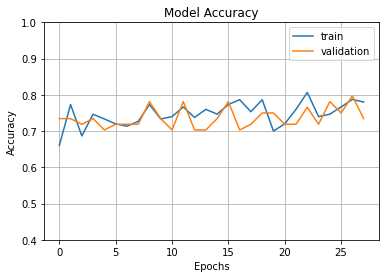

In [25]:
fig1 = plt.gcf()
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

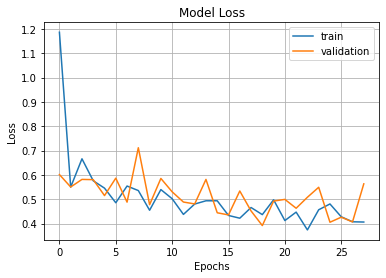

In [26]:
fig1 = plt.gcf()
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')

plt.legend(['train', 'validation'])
plt.show()
fig1.savefig('loss_plot.jpg')

***InceptionV3***

In [27]:
epochs= 10
model1 = Sequential()

pretrained_model= InceptionV3(include_top=False,
                   input_shape=(224,224,3),
                   pooling='avg',classes=2,
                   weights='imagenet')
print(len(pretrained_model.layers))

for layer in pretrained_model.layers:
        layer.trainable=False

model1.add(pretrained_model)
model1.add(Flatten())
model1.add(Dense(512, activation='relu'))
model1.add(Dense(256, activation='relu'))
model1.add(Dense(128, activation='relu'))
model1.add(Dense(64, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))

312


In [28]:

model1.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [29]:
History = model1.fit_generator(train_datagen_flow,
                              steps_per_epoch = 5,
                              validation_data = valid_datagen_flow, 
                              validation_steps = 1,
                              epochs=epochs,
                              verbose=1
                              )

Epoch 1/10
5/5 [==============================] - 13s 2s/step - loss: 0.6207 - accuracy: 0.7600 - val_loss: 0.5439 - val_accuracy: 0.7500
Epoch 2/10
5/5 [==============================] - 11s 2s/step - loss: 0.4950 - accuracy: 0.7600 - val_loss: 0.3460 - val_accuracy: 0.8438
Epoch 3/10
5/5 [==============================] - 14s 3s/step - loss: 0.3591 - accuracy: 0.8533 - val_loss: 0.3979 - val_accuracy: 0.8438
Epoch 4/10
5/5 [==============================] - 15s 3s/step - loss: 0.2973 - accuracy: 0.9187 - val_loss: 0.6287 - val_accuracy: 0.8125
Epoch 5/10
5/5 [==============================] - 14s 3s/step - loss: 0.3044 - accuracy: 0.8467 - val_loss: 0.6447 - val_accuracy: 0.8438
Epoch 6/10
5/5 [==============================] - 15s 3s/step - loss: 0.3244 - accuracy: 0.8600 - val_loss: 0.4580 - val_accuracy: 0.8750
Epoch 7/10
5/5 [==============================] - 14s 3s/step - loss: 0.2134 - accuracy: 0.9000 - val_loss: 0.3473 - val_accuracy: 0.8125
Epoch 8/10
5/5 [==================

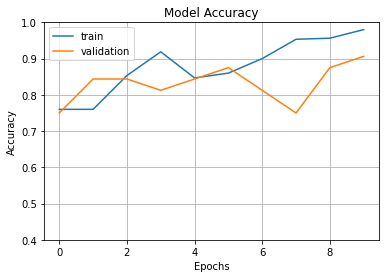

In [32]:
fig1 = plt.gcf()
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

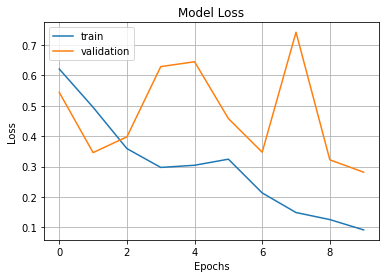

In [34]:
fig1 = plt.gcf()

plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')

plt.legend(['train', 'validation'])
plt.show()
fig1.savefig('loss_plot.jpg')

***VGG16***

In [35]:
model2 = Sequential()

pretrained_model = tf.keras.applications.VGG16(include_top=False,
                   input_shape=(224,224,3),
                   
                   weights='imagenet')
print(len(pretrained_model.layers))

for layer in pretrained_model.layers:
        layer.trainable=False
model2.add(pretrained_model)
model2.add(Flatten())
model2.add(Dense(512, activation='relu'))
model2.add(Dense(256, activation='relu'))
model2.add(Dense(128, activation='relu'))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

19


In [36]:
model2.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [37]:
History = model2.fit_generator(train_datagen_flow,
                              steps_per_epoch = 5,
                              validation_data = valid_datagen_flow, 
                              validation_steps = 1,
                              epochs=10,
                              verbose=1
                              )

Epoch 1/10
5/5 [==============================] - 24s 5s/step - loss: 0.9785 - accuracy: 0.6133 - val_loss: 0.6899 - val_accuracy: 0.7500
Epoch 2/10
5/5 [==============================] - 22s 5s/step - loss: 0.7119 - accuracy: 0.7812 - val_loss: 0.5011 - val_accuracy: 0.7500
Epoch 3/10
5/5 [==============================] - 21s 4s/step - loss: 0.4871 - accuracy: 0.7667 - val_loss: 0.5171 - val_accuracy: 0.9062
Epoch 4/10
5/5 [==============================] - 21s 4s/step - loss: 0.4753 - accuracy: 0.7600 - val_loss: 0.3653 - val_accuracy: 0.7812
Epoch 5/10
5/5 [==============================] - 21s 4s/step - loss: 0.2574 - accuracy: 0.9200 - val_loss: 0.1393 - val_accuracy: 0.9375
Epoch 6/10
5/5 [==============================] - 21s 4s/step - loss: 0.2799 - accuracy: 0.8533 - val_loss: 0.2616 - val_accuracy: 0.9062
Epoch 7/10
5/5 [==============================] - 23s 5s/step - loss: 0.2709 - accuracy: 0.8400 - val_loss: 0.2272 - val_accuracy: 0.8750
Epoch 8/10
5/5 [==================

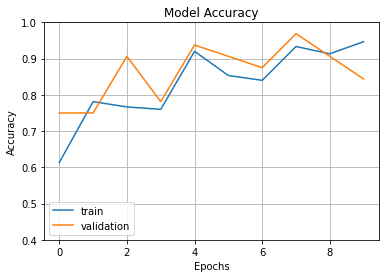

In [38]:
fig1 = plt.gcf()
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

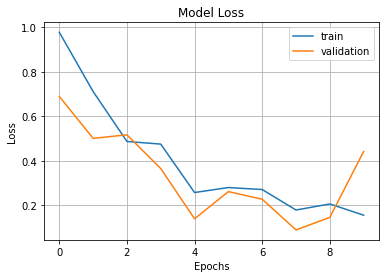

In [39]:
fig1 = plt.gcf()

plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')

plt.legend(['train', 'validation'])
plt.show()
fig1.savefig('loss_plot.jpg')

***ResNet50***

In [40]:
model3 = Sequential()

pretrained_model = tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(224,224,3),
                   
                   weights='imagenet')
print(len(pretrained_model.layers))

for layer in pretrained_model.layers:
        layer.trainable=False
model3.add(pretrained_model)
model3.add(Flatten())
model3.add(Dense(512, activation='relu'))
model3.add(Dense(256, activation='relu'))
model3.add(Dense(128, activation='relu'))
model3.add(Dense(64, activation='relu'))
model3.add(Dense(1, activation='sigmoid'))

175


In [41]:
model3.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [42]:
History = model3.fit_generator(train_datagen_flow,
                              steps_per_epoch = 5,
                              validation_data = valid_datagen_flow, 
                              validation_steps = 1,
                              epochs=10,
                              verbose=1
                              )

Epoch 1/10
5/5 [==============================] - 15s 3s/step - loss: 1.8915 - accuracy: 0.6067 - val_loss: 2.3128 - val_accuracy: 0.6875
Epoch 2/10
5/5 [==============================] - 12s 2s/step - loss: 0.8708 - accuracy: 0.6533 - val_loss: 0.6288 - val_accuracy: 0.7188
Epoch 3/10
5/5 [==============================] - 12s 2s/step - loss: 1.3270 - accuracy: 0.6933 - val_loss: 0.6856 - val_accuracy: 0.7812
Epoch 4/10
5/5 [==============================] - 12s 2s/step - loss: 1.6540 - accuracy: 0.6375 - val_loss: 0.5726 - val_accuracy: 0.8125
Epoch 5/10
5/5 [==============================] - 12s 2s/step - loss: 1.8042 - accuracy: 0.5200 - val_loss: 1.1592 - val_accuracy: 0.9062
Epoch 6/10
5/5 [==============================] - 12s 2s/step - loss: 2.3620 - accuracy: 0.7563 - val_loss: 2.0553 - val_accuracy: 0.3125
Epoch 7/10
5/5 [==============================] - 12s 2s/step - loss: 1.6413 - accuracy: 0.5267 - val_loss: 2.2200 - val_accuracy: 0.5938
Epoch 8/10
5/5 [==================

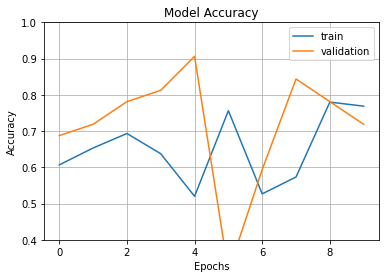

In [46]:
fig1 = plt.gcf()
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

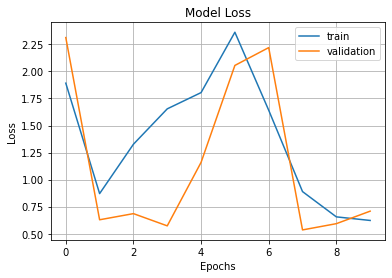

In [47]:
fig1 = plt.gcf()
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()
fig1.savefig('loss_plot.jpg')

***Code for predicting the label of image . You can check for different model by just changing model name in 2nd last line***

In [51]:
image_path = os.path.join(r'C:\Users\ghars\Downloads\Binary\train\malignant\2.jpg')
image = tf.keras.preprocessing.image.load_img(image_path)
resized_image = image.resize((224,224))
numpied_image = np.expand_dims(resized_image, 0)
tensored_image = tf.cast(numpied_image, tf.float32)
#label = model2.predict_classes(tensored_image/255)
label = (model2.predict((tensored_image)/255) > 0.5).astype("int32")
label

array([[1]])

***Confusion Matrix. Here also you can change model name for checking for different models.***

In [52]:
Y_pred = model1.predict(valid_datagen_flow)
y_pred=[]
for i in range(len(Y_pred)):
    if Y_pred[i][0]>0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)
        
print('Confusion Matrix')
print(metrics.confusion_matrix(valid_datagen_flow.classes, y_pred))
print ()

print('Classification Report')
target_names = ['Non nevus', 'Nevus']
print(metrics.classification_report(valid_datagen_flow.classes, y_pred, target_names=target_names))

print(valid_datagen_flow.class_indices)

Confusion Matrix
[[46 11]
 [18  3]]

Classification Report
              precision    recall  f1-score   support

   Non nevus       0.72      0.81      0.76        57
       Nevus       0.21      0.14      0.17        21

    accuracy                           0.63        78
   macro avg       0.47      0.47      0.47        78
weighted avg       0.58      0.63      0.60        78

{'benign': 0, 'malignant': 1}


In [69]:
model.save("model.h5")

In [70]:
model1.save("model1.h5")

In [71]:
model2.save("model2.h5")

In [72]:
model3.save("model3.h5")

c:\Users\ghars\anaconda3\envs\edaconda\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [60]:
#model.save_weights("model.h5")

In [61]:
#model1.save_weights("model1.h5")

In [62]:
#model2.save_weights("model2.h5")

In [63]:
#model3.save_weights("model3.h5")


[0]

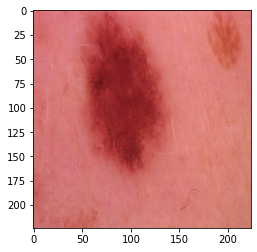

In [76]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import load_model
img = image.load_img(r'C:\Users\ghars\Downloads\Binary\test\benign\15.jpg',target_size=( 224, 224))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)
from keras.models import load_model
saved_model = tf.keras.models.load_model("model1.h5")
#saved_model=keras.models.load_weights("model2.h5")
#output = saved_model.predict(img)
Y_pred = saved_model.predict(img)
y_pred=[]
for i in range(len(Y_pred)):
    if Y_pred[i][0]>0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)
        
y_pred
#print( y_pred.class_indices)
#output
#print(output)



In [68]:
image_path = os.path.join(r'C:\Users\ghars\Downloads\Binary\test\malignant\186.jpg')
image = tf.keras.preprocessing.image.load_img(image_path)
resized_image = image.resize((224,224))
numpied_image = np.expand_dims(resized_image, 0)
tensored_image = tf.cast(numpied_image, tf.float32)
label = model1.predict_classes(tensored_image/255)
label

AttributeError: 'Sequential' object has no attribute 'predict_classes'